# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

In [2]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

# 設定 data_path
dir_data = './data'

In [3]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./data\application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

In [4]:
app_train.shape

(307511, 122)

In [5]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Numbers of remain columns: 72


D:\Anacoda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


column name: CNT_CHILDREN


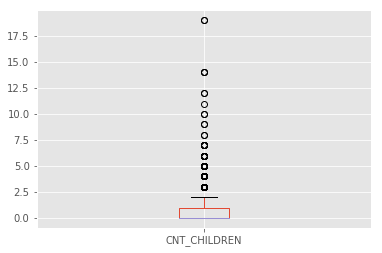

column name: AMT_INCOME_TOTAL


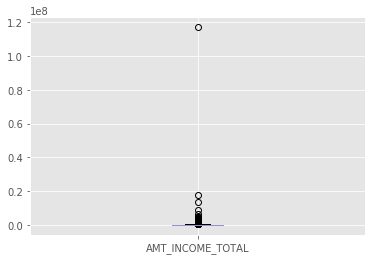

column name: AMT_CREDIT


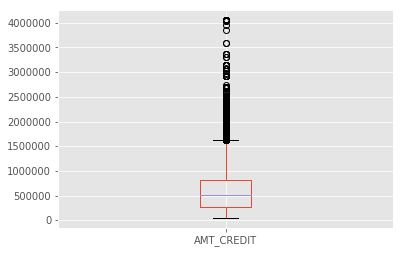

column name: REGION_POPULATION_RELATIVE


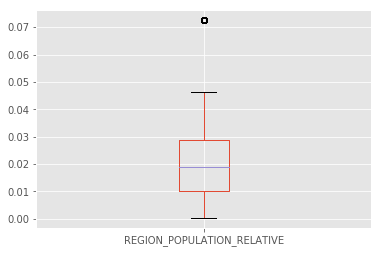

column name: DAYS_EMPLOYED


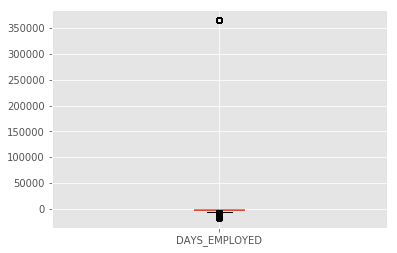

column name: DAYS_REGISTRATION


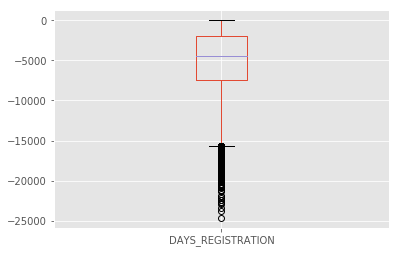

column name: REGION_RATING_CLIENT


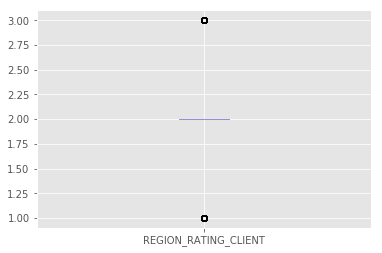

column name: REGION_RATING_CLIENT_W_CITY


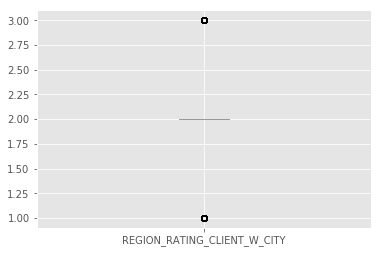

column name: HOUR_APPR_PROCESS_START


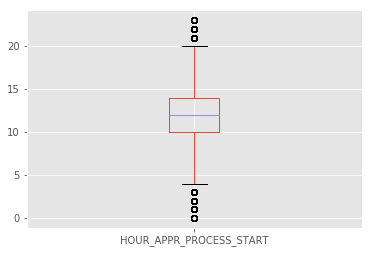

In [6]:
from scipy import stats

# 先篩選數值型的欄位
"""
YOUR CODE HERE, fill correct data types (for example str, float, int, ...)
"""
dtype_select = [np.dtype('float64'), np.dtype('int64')]
numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])
numeric_columns
# 再把只有 2 值 (通常是 0,1) 的欄位去掉
# 並過濾掉 uuid
numeric_columns = list(app_train[numeric_columns].columns[list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 and len(x.unique())!=307511))])
print(f'Numbers of remain columns: {len(numeric_columns)}')

# 使用 Standard Deviation Method 和 Interquartile Range Method 和 Z-Score 檢測可能有 outlier 的欄位
suspect_sde = []
suspect_ire = []
suspect_zse = []

for col in numeric_columns:
    # Standard Deviation Method
    data_mean, data_std = app_train[col].mean(), app_train[col].std()
    lower, upper = data_mean -  3 * data_std, data_mean + 3 * data_std
    outliers = [x for x in app_train[col] if x < lower or x > upper]
    if len(outliers) > 0:
        suspect_sde.append(col)
    
    # Interquartile Range Method
    q25, q75 = np.percentile(app_train[col], 25), np.percentile(app_train[col], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in app_train[col] if x < lower or x > upper]
    if len(outliers) > 0:
        suspect_ire.append(col)
    
    # z-score detect menthod
    data = np.abs(stats.zscore(app_train[col][:]))
    outliers = [x for x in data if x > 3 or x < -3]
    if len(outliers) > 0:
        suspect_zse.append(col)
        
# 畫可疑欄位的 box plot
for col in suspect_ire:
    print(f'column name: {col}')
    app_train[[col]].boxplot()
    plt.show()


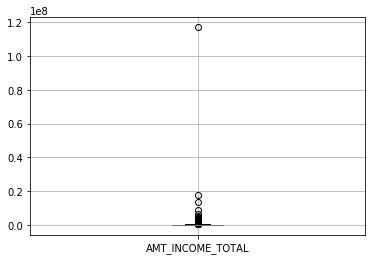

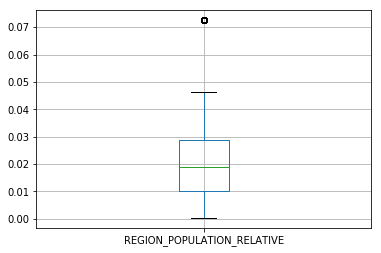

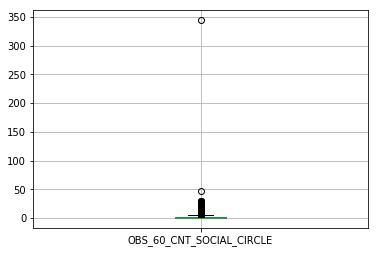

In [60]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# REGION_POPULATION_RELATIVE
# OBS_60_CNT_SOCIAL_CIRCLE
app_train[['AMT_INCOME_TOTAL']].boxplot()
plt.show()
app_train[['REGION_POPULATION_RELATIVE']].boxplot()
plt.show()
app_train[['OBS_60_CNT_SOCIAL_CIRCLE']].boxplot()
plt.show()

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


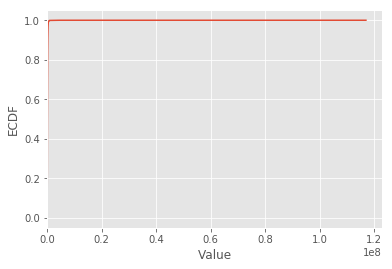

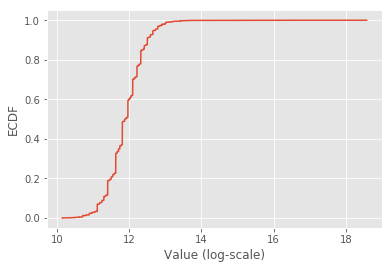

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF

# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
YOUR CODE HERE
"""
cdf = ECDF(app_train['AMT_INCOME_TOTAL'])

plt.plot(cdf.x[1:], cdf.y[1:])
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.x[1:].min(), cdf.x[1:].max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.x[1:])), cdf.y[1:])
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64


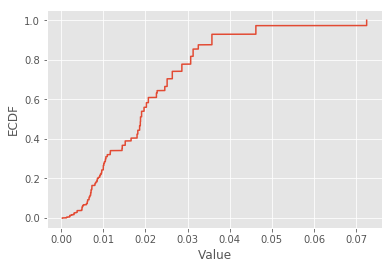

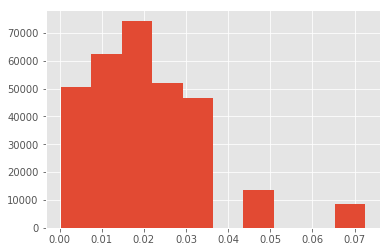

0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
0.031329    11321
0.028663    11157
0.019101     8694
0.072508     8412
0.020713     8066
0.018850     7668
0.020246     7178
0.018634     7038
0.022625     6943
0.015221     6824
0.032561     6636
0.024610     6404
0.019689     6172
0.018029     6167
0.018801     6108
0.018209     6052
0.014520     4785
0.016612     4408
0.007020     4105
0.022800     3807
0.010032     3570
0.010006     3563
0.014464     3422
0.004960     3300
0.011703     3252
            ...  
0.006008     1796
0.003069     1783
0.008575     1763
0.008474     1740
0.007274     1724
0.007114     1684
0.006305     1672
0.008068     1668
0.008866     1654
0.006671     1653
0.002042     1642
0.003813     1616
0.005084     1482
0.006296     1225
0.005313     1218
0.003818     1212
0.003122     1147
0.006233     1087
0.005002     1068
0.002134     1051
0.004849     1038
0.005144      967
0.002506      944
0.003541      627
0.001276  

In [8]:
# 最大值落在分布之外
print(app_train['REGION_POPULATION_RELATIVE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
Your Code Here
"""
cdf = ECDF(app_train['REGION_POPULATION_RELATIVE'])


plt.plot(cdf.x[1:], cdf.y[1:])
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


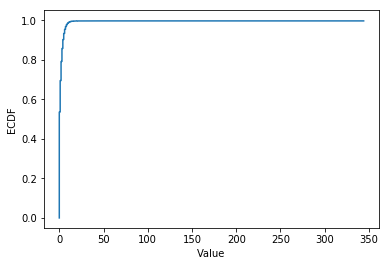

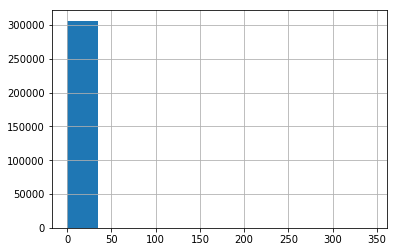

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [81]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
Your Code Here
"""
cdf = ECDF(app_train['OBS_60_CNT_SOCIAL_CIRCLE'])


plt.plot(cdf.x[1:], cdf.y[1:])
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

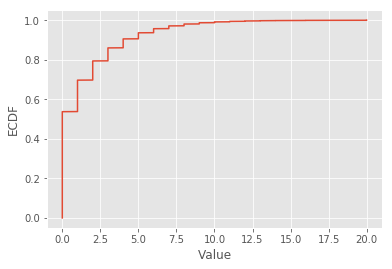

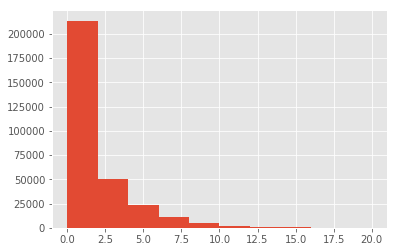

In [9]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製
"""
Your Code Here
"""
data = app_train['OBS_60_CNT_SOCIAL_CIRCLE'][app_train['OBS_60_CNT_SOCIAL_CIRCLE'] <= 20]
cdf = ECDF(data)


plt.plot(cdf.x[1:], cdf.y[1:])
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

data.hist()
plt.show()